In [28]:
import numpy as np
import matplotlib

# define parameters .. notes we have equal k and c values for the springs
damper_c = 5.5
spring_k = -30.5
mass = 1.7 #kg 
vertabrae_inertia = 1 #

# Define the attachment points. The first row corresponds to the middle attachment point.
# The second row corresponds to the top attachement point and third is bottom attachment point.

bar_length = 0.5 # meters
s1 = np.array([0,0])
s2 = np.array([-bar_length, bar_length])
s3 = np.array([-bar_length, -bar_length])

S_matrix = np.array([s1, s2, s3])

# final_positions = [x, y, theta]
# force_vector = [n1 - s1, n1 - s2, n2 - s1, n2 - s3] (calculated using Drews)
def input_vector(force_vector, final_positions, s = S_matrix, k = spring_k, barlength = 0.5) :
    x = final_positions[0]
    y = final_positions[1]
    th = final_positions[2]

    s1 = s[0,:]
    s2 = s[1,:]
    s3 = s[2,:]
    
    print(s1, s2,s3)
    # define nodes
    n1 = np.array([x + np.cos(2 * np.pi/3 + th) * barlength, y + np.sin(2 * np.pi/ 3 + th) * barlength])
    n2 = np.array([x + np.cos(-2 * np.pi/ 3 + th) * barlength, y + np.sin(-2 * np.pi/ 3 + th) * barlength])
    l2_dist_vector = np.array([np.linalg.norm(np.array(n1 - s1)), 
                               np.linalg.norm(np.array(n1 - s2)), 
                               np.linalg.norm(np.array(n2 - s1)), 
                               np.linalg.norm(np.array(n2 - s3))])
    kay = np.ones(4) * 1/k
    K_inv = np.diag(kay)
    
    return l2_dist_vector - np.dot(force_vector, K_inv)

# helper function used to compute force component ... they all have similar structure.
def force_component(direction, ddt_node, node, u, att, k = spring_k, c = damper_c) :
    spring_comp = k * (np.linalg.norm(node - att) - u)
    damping_comp = - c * ((node[0] - att[0]) * ddt_node[0] + (node[1] - att[1]) * ddt_node[1]) / np.linalg.norm(node - att)
    if (direction == True) : # X component
        direction_comp = (node[0] - att[0]) / np.linalg.norm(node - att)
    else :
        direction_comp = (node[1] - att[1]) / np.linalg.norm(node - att)
    return direction_comp * (spring_comp + damping_comp)

# returns the acceleration terms
    """nodes, derivated of nodes, the current position as the center of mass, inputs, attachmenent points"""
def eqn_motion(nodes, ddt_Nodes, current_position, inputs, g, att1 = s1, att2 = s2, att3 = s3, m = 1.7) :
    u1 = inputs[0]
    u2 = inputs[1]
    u3 = inputs[2]
    u4 = inputs[3]
    
    node1 = nodes[0,:]
    node2 = nodes[1,:]
    
    # define for x direction
    node1_rel = nodes[0,:] - current_position
    node2_rel = nodes[1,:] - current_position
    
    # assign node_ddt
    ddt_node1 = ddt_Nodes[0,:]
    ddt_node2 = ddt_Nodes[1,:]
    
    x1t = force_component(True, ddt_node1, node1, u1, att1)
    x2t = force_component(True, ddt_node1, node1, u2, att2)
    x3t = force_component(True, ddt_node2, node2, u3, att1)
    x4t = force_component(True, ddt_node2, node2, u4, att3)
    
    x_acc = 1 / m * (x1t + x2t + x3t + x4t)
    
    y1t = force_component(False, ddt_node1, node1, u1, att1) 
    y2t = force_component(False, ddt_node1, node1, u2, att2)
    y3t = force_component(False, ddt_node2, node2, u3, att1)
    y4t = force_component(False, ddt_node2, node2, u4, att3)
    y_acc = 1 / m *(y1t + y2t + y3t +y4t) - g
    
    pt1 = node1_rel[0] * (force_component(False, ddt_node1, node1, u1, att1) +  force_component(False, ddt_node1, node1, u2, att2))
    pt2 =  node2_rel[0] * (force_component(False, ddt_node2, node2, u3, att1) + force_component(False, ddt_node2, node2, u4, att3))
    pt3 = - node1_rel[1] * (force_component(True, ddt_node1, node1, u1, att1) + force_component(True, ddt_node1, node1, u2, att2))
    pt4 = - node2_rel[1] * (force_component(True, ddt_node2, node2, u3, att1) + force_component(True, ddt_node2, node2, u4, att3))
    psi_acc =  pt1 + pt2 + pt3 + pt4
                
    return x_acc, y_acc, psi_acc

# Intialize: Compute the node terms, derivates based on relative frame and pass into eqn_motion
#            to get acceleration terms
def initialize(initial_state, inputs, g,  barlength = 0.5, delta =2 * np.pi / 3) :
    x1 = initial_state[0]
    x1dot = initial_state[1]
    x2 = initial_state[2]
    x2dot = initial_state[3]
    theta = initial_state[4]
    thetadot = initial_state[5]
    
    # Node positions
    n1 = np.array([x1 + barlength * np.cos(delta + theta), x2 + barlength * np.sin(delta + theta)])
    n2 = np.array([x1 + barlength * np.cos(-delta + theta), x2 + barlength * np.sin(-delta + theta)])

    n1_dot = np.array([x1dot - barlength * np.sin(delta + theta) * thetadot,
                       x2dot + barlength * np.cos(delta + theta) * thetadot])
    # Node derivates
    n2_dot = np.array([x1dot - barlength * np.sin(-delta + theta) * thetadot,
                       x2dot + barlength * np.cos(-delta + theta) * thetadot])
        
    # Nodes matrix, center of mass (to pass in to eqn of motion method)
    Nodes = np.array([n1, n2])
    com = np.array([x1, x2])
    ddt_Nodes = np.array([n1_dot, n2_dot])
    
    return eqn_motion(Nodes, ddt_Nodes, com, inputs, g)
    
def euler_integration(states_initial, x1_ddot, x2_ddot, psi_ddot, dt, t, inputs, g) :
    
    N = int(t / dt)
    print(N)
    state_matrix = np.zeros((N + 1,6))
    state_matrix[0,:] = states_initial
    # update states
    for i in range(N):
        psi_dot_next = states_initial[5] + dt * psi_ddot
        x2_dot_next = states_initial[3] + dt * x2_ddot
        x1_dot_next = states_initial[1] + dt* x1_ddot

        x1_next = states_initial[0] + 1 / 2 * dt* x1_dot_next
        x2_next = states_initial[2] + 1/2 * dt * x2_dot_next
        psi_next = states_initial[4] + 1/2 * dt * psi_dot_next

        states_initial = np.array([x1_next, x1_dot_next, x2_next, x2_dot_next, psi_next, psi_dot_next])
        state_matrix[i + 1, :] = states_initial

        # Compute acceleration based on new 

        x1_ddot, x2_ddot, psi_ddot = initialize(states_initial, inputs, g)
        state_matrix[i + 1,:] = states_initial
    return state_matrix
    
    

In [43]:
# Define initial States
# x, xdot, y, ydot, psi, psidot

# if init and final pos are the same with 0 inirtial forces then the inital acc should be zero
bar_length = 0.5
init = np.array([bar_length, 0, 0, 0, 0, 0])
final_pos = np.array([bar_length + 0.1, 0.3, 0])
#final_pos = np.array([bar_length - 0.2, -.2, 0])
force_initial = np.array([0, 0, 0, 0])

inputs = input_vector(force_initial, final_pos)

# compute the initial acceleration terms

ddotx1, ddotx2, ddotpsi = initialize(init, inputs, 0)
print(ddotx1, ddotx2, ddotpsi)

# at time = 0


[0. 0.] [-0.5  0.5] [-0.5 -0.5]
7.057847332424141 6.874292575121357 -5.227859159787939


In [44]:
simulations = euler_integration(init, ddotx1, ddotx2, ddotpsi, 0.01, 20, inputs, 9.81)

2000


(2001, 6)


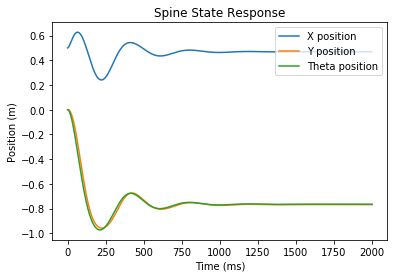

In [46]:
# x
import matplotlib.pyplot as plt
x = simulations[:,0]
y = simulations[:,2]
th = simulations[:, 4]

print(simulations.shape)
xx = plt.plot(x)
yy = plt.plot(y)
thth = plt.plot(th)

plt.legend(('X position', 'Y position', 'Theta position'), loc='upper right')

plt.xlabel('Time (ms)')
plt.ylabel('Position (m)')
plt.title('Spine State Response')


plt.show()